### Predict El Nino Southern Oscillation with CICMoD dataset

In this project we work with **C**limate **I**ndex **C**ollection based on **Mo**del **D**ata (CICMoD) dataset (https://github.com/MarcoLandtHayen/climate_index_collection) to predict sea-surface temperature (SST) anomalies related to El Nino Southern Oscillation (ENSO). Several SST anomaly indices are included in CICMoD dataset, area-averaged over different regions of Tropical Pacific. Most prominent is the ENSO 3.4 index ("ENSO_34"), which focusses on Nino 3.4 region. We will use this index with various time lags (0, 1, 2, 3, 6 months) as **target**. The remaining indices included in CICMoD serve as **input** time series. **Note:** We won't use the other ENSO indices as inputs, due to expected high correlation to our target.

**Outline in this experiment:**
- Create **time lagged target indices** from ENSO34.
- Check how remaining input time series **correlate** to lagged target indices.
- Train **CNN/fc** model.
- (Hyper-)parameter **optimization**.
- Try plain-vanilla **LSTM/fc** model.
- Add various **Attention** mechanisms to LSTM/fc model: Try to find simple form for **input** and **temporal** attention.
- Try **ESN model with LRP** as alternative.

In [49]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import inspect
import itertools

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input,
    Dense,
    LSTM,
    Conv1D,
    MaxPooling1D,
    Dropout,
    Flatten,
    BatchNormalization,
    LeakyReLU,
    concatenate,
)
from tensorflow.keras.optimizers import (
    SGD,
    Adam,
)
from tensorflow.keras.losses import (
    CategoricalCrossentropy
)
import tensorflow.keras.initializers as tfi
import tensorflow.keras.regularizers as tfr
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K

from cicmod_application.preprocessing import split_sequence
from cicmod_application.events import (
    el_nino,
    la_nina,
)

from numpy.testing import assert_allclose, assert_almost_equal

# online
# CSV_PATH = "https://github.com/MarcoLandtHayen/climate_index_collection/releases/download/v2022.09.09.1/climate_indices.csv"
# offline
CSV_PATH = "climate_indices.csv"

In [2]:
from matplotlib import cycler

colors = cycler("color", ["#EE6666", "#3388BB", "#9988DD", "#88BB44", "#FFBBBB"])
plt.rc("figure", facecolor="w")
plt.rc("axes", edgecolor="#E6E6E6", axisbelow=True, grid=False, prop_cycle=colors)
plt.rc("grid", color="grey", linestyle="solid")
plt.rc("xtick", direction="out", color="gray")
plt.rc("ytick", direction="out", color="gray")
plt.rc("patch", edgecolor="#E6E6E6")
plt.rc("lines", linewidth=2)

In [3]:
class arg_dict(dict):
    def get_args(self, function):
        return dict(
            [
                [arg, self[arg]]
                for arg in inspect.getfullargspec(function).args
                if arg in self
            ]
        )


class DataFrameMultiColumn(pd.DataFrame):
    def loc_multicolumn(self, keys):
        depth = lambda L: isinstance(L, list) and max(map(depth, L)) + 1

        result = []
        col = self.columns

        # if depth of keys is 1, all keys need to be true
        if depth(keys) == 1:
            for c in col:
                # select all columns which contain all keys
                if set(keys).issubset(set(c)):
                    result.append(c)
        # depth of 2 indicates,
        # the product of all sublists will be formed
        elif depth(keys) == 2:
            keys = list(itertools.product(*keys))
            for c in col:
                for k in keys:
                    # select all columns which contain all keys
                    if set(k).issubset(set(c)):
                        result.append(c)

        else:
            raise ValueError("Depth of the keys list exceeds 2")

        # return with .loc command
        return self.loc[:, result]

## Model definitions

In [34]:
def set_CNN_fc(
    CNN_filters,
    CNN_kernel_sizes,
    pooling,
    fc_units,
    fc_hidden_activation,
    n_epochs,
    batch_size,
    learning_rate,
    loss_function,
    weight_init,
    bias_init,
    output_units=1,
    output_activation='linear',
    name=None,
):
    """
    Sets up CNN/fc model. Can be used for multi-run experiments.

    Parameters:
    ===========
    CNN_filters: Array of integer numbers to specify the number of feature maps in all CNN layers.
    CNN_kernel_sizes: Array of integer numbers to specify the filter sizes in all CNN layers.
    fc_units: Array of integer numbers to specify the number of units in all hidden fc layers.
    fc_hidden_activation: Activation function for hidden fc layers, 'linear' or 'sigmoid'.
    n_epochs: Integer number to specify the number of epochs for a single run.
    batch_size: Integer number to specify the batch size used for training the model.
    learning_rate: Floating point number to set the learning rate for the optimizer.
    loss_function: String ('mse', 'custom_mse', 'custom_loss') to choose the loss function.

    Returns:
    ========
    model

    """

    # Start model definition:
    if name is not None and isinstance(name, str):
        model = Sequential(name=name)
    else:
        model = Sequential()

    # Add input layer:
    input_shape = (input_length, len(input_features))
    model.add(Input(shape=input_shape))

    # Add CNN layer(s):
    for i in range(len(CNN_filters)):
        model.add(
            Conv1D(
                filters=CNN_filters[i],
                kernel_size=CNN_kernel_sizes[i],
                strides=1,
                kernel_initializer=weight_init,
                bias_initializer=bias_init,
            )
        )
        model.add(BatchNormalization())
        model.add(LeakyReLU(alpha=0.3))

        # Add max pooling, if input_length is equal or above 40d to limit number of trainable parameters:
        if pooling[i] == True:
            model.add(MaxPooling1D(pool_size=2))

    # Flatten CNN output:
    model.add(Flatten())

    # Add hidden fc layer(s):
    for i in range(len(fc_units)):
        model.add(
            Dense(
                units=fc_units[i],
                activation=fc_hidden_activation,
                kernel_initializer=weight_init,
                bias_initializer=bias_init,
            )
        )

    # Add output unit:
    model.add(
        Dense(
            units=output_units,
            name="output",
            activation=output_activation,
            kernel_initializer=weight_init,
            bias_initializer=bias_init,
        )
    )

    # Compile model with desired loss function:
    model.compile(
        optimizer=Adam(learning_rate=learning_rate), loss=loss_function, metrics=([])
    )

    return model

In [29]:
def set_LSTM_fc(
    LSTM_units,
    fc_units,
    fc_hidden_activation,
    n_epochs,
    batch_size,
    learning_rate,
    loss_function,
    input_data,
    name=None,
):
    """
    Sets up LSTM/fc model. Can be used for multi-run experiments.

    Parameters:
    ===========
    LSTM_units: Array of integer numbers to specify the number of units in all hidden LSTM layers.
    fc_units: Array of integer numbers to specify the number of units in all hidden fc layers.
    fc_hidden_activation: Activation function for hidden fc layers, 'linear' or 'sigmoid'.
    n_epochs: Integer number to specify the number of epochs for a single run.
    batch_size: Integer number to specify the batch size used for training the model.
    learning_rate: Floating point number to set the learning rate for the optimizer.
    loss_function: String ('mse', 'custom_mse', 'custom_loss') to choose the loss function.
    input_data : np.ndarray containing the input data. Only needed to set CNN topology.

    Returns:
    ========
    model

    """

    # Start model definition:
    if name is not None and isinstance(name, str):
        model = Sequential(name=name)
    else:
        model = Sequential()
    # Add input layer:
    input_shape = (input_length, len(input_features))
    model.add(Input(shape=input_shape))

    # Add LSTM layer(s):
    for i in range(len(LSTM_units)):

        # In case we have multiple LSTM layers, we want to pass ALL hidden states to the subsequent LSTM layer.
        # Only for the last (and possibly ONLY) LSTM layer we only need the final hidden states.
        # This can be specified by return_sequences=True/False.
        # So check if we reached the last LSTM layer yet:
        if i < (len(LSTM_units) - 1):
            model.add(
                LSTM(
                    units=LSTM_units[i],
                    bias_initializer=bias_init,
                    return_sequences=True,
                )
            )
        else:
            model.add(
                LSTM(
                    units=LSTM_units[i],
                    bias_initializer=bias_init,
                    return_sequences=False,
                )
            )

    # Add hidden fc layer(s):
    for i in range(len(fc_units)):
        model.add(
            Dense(
                units=fc_units[i],
                activation=fc_hidden_activation,
                kernel_initializer=weight_init,
                bias_initializer=bias_init,
            )
        )

    # Add output unit:
    model.add(
        Dense(
            units=1,
            name="output",
            activation="linear",
            kernel_initializer=weight_init,
            bias_initializer=bias_init,
        )
    )

    # Compile model with desired loss function:
    model.compile(
        optimizer=Adam(learning_rate=learning_rate), loss=loss_function, metrics=([])
    )

    return model

In [30]:
def set_CNN_LSTM(
    CNN_filters,
    CNN_kernel_sizes,
    LSTM_units,
    n_epochs,
    batch_size,
    learning_rate,
    loss_function,
):
    """
    Sets up CNN/LSTM model. Can be used for multi-run experiments.

    Parameters:
    ===========
    CNN_filters: Array of integer numbers to specify the number of feature maps in all CNN layers.
    CNN_kernel_sizes: Array of integer numbers to specify the filter sizes in all CNN layers.
    LSTM_units: Array of integer numbers to specify the number of units in all hidden LSTM layers.
    n_epochs: Integer number to specify the number of epochs for a single run.
    batch_size: Integer number to specify the batch size used for training the model.
    learning_rate: Floating point number to set the learning rate for the optimizer.
    loss_function: String ('mse', 'custom_mse', 'custom_loss') to choose the loss function.

    Returns:
    ========
    model

    """

    # Start model definition:
    model = Sequential()

    # Add input layer:
    input_shape = (input_length, len(input_features))
    model.add(Input(shape=input_shape))

    # Add CNN layer(s):
    for i in range(len(CNN_filters)):
        model.add(
            Conv1D(
                filters=CNN_filters[i],
                kernel_size=CNN_kernel_sizes[i],
                strides=1,
                kernel_initializer=weight_init,
                bias_initializer=bias_init,
            )
        )
        model.add(BatchNormalization())
        model.add(LeakyReLU(alpha=0.3))

        # Add max pooling, if input_length is equal or above 40d to limit number of trainable parameters:
        if input_length >= 20:
            model.add(MaxPooling1D(pool_size=2))

    # Add hidden LSTM layer(s):
    for i in range(len(LSTM_units)):

        # In case we have multiple LSTM layers, we want to pass ALL hidden states to the subsequent LSTM layer.
        # Only for the last (and possibly ONLY) LSTM layer we only need the final hidden states.
        # This can be specified by return_sequences=True/False.
        # So check if we reached the last LSTM layer yet:
        if i < (len(LSTM_units) - 1):
            model.add(
                LSTM(
                    units=LSTM_units[i],
                    bias_initializer=bias_init,
                    return_sequences=True,
                )
            )
        else:
            model.add(
                LSTM(
                    units=LSTM_units[i],
                    bias_initializer=bias_init,
                    return_sequences=False,
                )
            )

    # Add output unit:
    model.add(
        Dense(
            units=1,
            name="output",
            activation="linear",
            kernel_initializer=weight_init,
            bias_initializer=bias_init,
        )
    )

    # Compile model with desired loss function:
    model.compile(
        optimizer=Adam(learning_rate=learning_rate), loss=loss_function, metrics=([])
    )

    return model

### Load data

Load collection of climate indices directly from GitHub release.

In [4]:
climind = pd.read_csv(CSV_PATH)

# Set index:
climind = climind.set_index(["model", "year", "month", "index"]).unstack(level=-1)[
    "value"
]
climind

index                  AMO   ENSO_12    ENSO_3   ENSO_34    ENSO_4    NAO_PC  \
model year month                                                               
CESM  1    1     -0.045584  0.878723  1.793537  2.277095  1.539571  1.494980   
           2     -0.055288  0.871110  1.725915  1.881192  1.460391  0.628604   
           3      0.000295  0.641493  1.292365  1.510816  1.266292  1.332836   
           4      0.017316  0.373644  0.930377  1.034762  0.775709  0.226980   
           5      0.031327 -0.038862  0.335949  0.702846  0.743190  0.995570   
...                    ...       ...       ...       ...       ...       ...   
FOCI  1000 8      0.178689  0.522490  1.009402  1.137735  1.011215  0.906418   
           9      0.098525  0.310882  0.931236  1.269963  1.355198  0.669222   
           10     0.012815  0.201341  0.842481  1.186615  1.407205  0.515824   
           11    -0.028865  0.250733  0.882067  1.289584  1.747254 -0.928136   
           12    -0.006059  0.284155  0.622142  1.097104  1.292274 -0.762554   

index               NAO_ST        NP    PDO_PC  PREC_SAHEL  ...   SSS_ENA  \
model year month                                            ...             
CESM  1    1      1.571751 -0.624027  0.354552   -0.000226  ...  0.377755   
           2      1.635490 -0.794662  0.391417   -0.002575  ...  0.088257   
           3      0.489595 -1.425871  0.566098   -0.095461  ...  0.121279   
           4      0.473761 -0.272417  0.879974   -0.121519  ...  0.204674   
           5      2.401551 -0.381626  1.086773    0.400654  ... -0.174217   
...                    ...       ...       ...         ...  ...       ...   
FOCI  1000 8      1.207901 -0.204993 -0.748606    0.684613  ... -0.903461   
           9      1.404237  0.132056 -0.420135    0.739803  ... -1.069282   
           10     1.190851 -0.353718 -0.232508   -0.029205  ... -1.003289   
           11    -1.419175  1.089200 -0.381073   -0.004869  ... -0.674776   
           12    -0.685174  0.324010 -0.595900    0.072165  ... -0.616161   

index               SSS_NA    SSS_SA   SSS_WNA  SST_ESIO  SST_HMDR   SST_MED  \
model year month                                                               
CESM  1    1      0.361125 -0.650658  0.001022  0.483008  0.070793  0.032231   
           2      0.084034 -0.552023 -0.027617  0.602004  0.141540  0.036850   
           3      0.091827 -0.383901 -0.117263  0.359004  0.199297 -0.004955   
           4      0.097583 -0.218266 -0.047506  0.066606  0.152572 -0.107935   
           5     -0.365616 -0.188526 -0.354763  0.090692  0.205236 -0.138338   
...                    ...       ...       ...       ...       ...       ...   
FOCI  1000 8     -0.571605 -0.096008  0.587311 -0.194002  0.054469  0.091777   
           9     -0.607013 -0.043860  0.796168 -0.228907  0.053131  0.274988   
           10    -0.415460  0.055235  0.992450  0.001155 -0.029871  0.225920   
           11    -0.078932  0.135558  0.973861  0.029547 -0.074635  0.077247   
           12    -0.049702  0.477039  0.880939  0.191145 -0.241239  0.089911   

index              SST_TNA   SST_TSA  SST_WSIO  
model year month                                
CESM  1    1      0.038024  0.526206 -0.316788  
           2      0.070549  0.416427 -0.276104  
           3      0.160956  0.378252 -0.186131  
           4      0.023744  0.319001 -0.130724  
           5     -0.041518  0.126895 -0.144448  
...                    ...       ...       ...  
FOCI  1000 8      0.026577  0.050525  0.123432  
           9      0.030738 -0.008511  0.028916  
           10    -0.087775 -0.100116  0.055975  
           11    -0.167492 -0.162180  0.172732  
           12    -0.279017  0.093415 -0.048286  

[23988 rows x 29 columns]

### Prepare inputs and targets

Most prominent is the ENSO 3.4 index ("ENSO_34"), which focusses on Nino 3.4 region. We will use this index with various time lags (0, 1, 2, 3, 6 months) as **target**. The remaining indices included in CICMoD serve as **input** time series. **Note:** We will exclude *all* ENSO indices from inputs, due to expected high correlation to our target.

In [7]:
# Separate data by model, reset index and drop columns year and month:
climind_FOCI = climind.loc[("FOCI")].reset_index().drop(columns=["year", "month"])
climind_CESM = climind.loc[("CESM")].reset_index().drop(columns=["year", "month"])

# Exclude ENSO indices to form input features:
input_FOCI = climind_FOCI.loc[:, ["ENSO" not in col for col in climind_FOCI.columns]]
input_CESM = climind_CESM.loc[:, ["ENSO" not in col for col in climind_CESM.columns]]

# Extract ENSO_34 index:
target_FOCI = climind_FOCI.loc[:, climind_FOCI.columns == "ENSO_34"]
target_CESM = climind_CESM.loc[:, climind_CESM.columns == "ENSO_34"]

# Create lagged targets with time lag 1, 2, 3, 6 months:
target_FOCI_lag1 = target_FOCI["ENSO_34"][1:-5].values
target_FOCI_lag2 = target_FOCI["ENSO_34"][2:-4].values
target_FOCI_lag3 = target_FOCI["ENSO_34"][3:-3].values
target_FOCI_lag6 = target_FOCI["ENSO_34"][6:].values
target_CESM_lag1 = target_CESM["ENSO_34"][1:-5].values
target_CESM_lag2 = target_CESM["ENSO_34"][2:-4].values
target_CESM_lag3 = target_CESM["ENSO_34"][3:-3].values
target_CESM_lag6 = target_CESM["ENSO_34"][6:].values

# Erase last 6 rows from inputs and unlagged target, to keep dimensions right:
input_FOCI = input_FOCI[:-6]
input_CESM = input_CESM[:-6]
target_FOCI = target_FOCI[:-6]
target_CESM = target_CESM[:-6]


# Add lagged targets as new columns:
target_FOCI["ENSO_34_lag1"] = target_FOCI_lag1
target_FOCI["ENSO_34_lag2"] = target_FOCI_lag2
target_FOCI["ENSO_34_lag3"] = target_FOCI_lag3
target_FOCI["ENSO_34_lag6"] = target_FOCI_lag6
target_CESM["ENSO_34_lag1"] = target_CESM_lag1
target_CESM["ENSO_34_lag2"] = target_CESM_lag2
target_CESM["ENSO_34_lag3"] = target_CESM_lag3
target_CESM["ENSO_34_lag6"] = target_CESM_lag6

# Create dictonaries
model_names = ["FOCI", "CESM"]

d = dict(
    FOCI=input_FOCI,
    CESM=input_CESM,
)
input_df = pd.concat(d.values(), axis=1, keys=d.keys())
d = dict(
    FOCI=target_FOCI,
    CESM=target_CESM,
)
target_df = pd.concat(d.values(), axis=1, keys=d.keys())

target_featur_names = target_df["FOCI"].columns
# Check dimensions:
print("FOCI inputs shape (time steps, features): ", input_df["FOCI"].shape)
print("CESM inputs shape (time steps, features): ", input_df["CESM"].shape)
print("\nFOCI target shape (time steps, features): ", target_df["FOCI"].shape)
print("CESM target shape (time steps, features): ", target_df["CESM"].shape)

FOCI inputs shape (time steps, features):  (11994, 25)
CESM inputs shape (time steps, features):  (11994, 25)

FOCI target shape (time steps, features):  (11994, 5)
CESM target shape (time steps, features):  (11994, 5)


### Create a el nino and la nina and neutral df for one hot enconding

In [9]:
target_FOCI = DataFrameMultiColumn(target_FOCI)
target_CESM = DataFrameMultiColumn(target_CESM)

In [10]:
threshold = 1
mel = 5

## CESM 
df_target_el_nino_CESM = target_CESM.apply(
    el_nino,
    axis=0,
    raw=True,
    result_type=None,
    **dict(threshold=threshold, 
           min_event_length=mel)
)
df_target_la_nina_CESM = target_CESM.apply(
    la_nina,
    axis=0,
    raw=True,
    result_type=None,
    **dict(threshold=-threshold, 
           min_event_length=mel)
)
df_target_neutral_CESM = -df_target_el_nino_CESM & -df_target_la_nina_CESM

d = {"el_nino": df_target_el_nino_CESM, "la_nina": df_target_la_nina_CESM, "neutral": df_target_neutral_CESM}
df_target_CESM = pd.concat(d.values(), axis=1, keys=d.keys())

## FOCI 
df_target_el_nino_FOCI = target_FOCI.apply(
    el_nino,
    axis=0,
    raw=True,
    result_type=None,
    **dict(threshold=threshold, 
           min_event_length=mel)
)
df_target_la_nina_FOCI = target_FOCI.apply(
    la_nina,
    axis=0,
    raw=True,
    result_type=None,
    **dict(threshold=-threshold, 
           min_event_length=mel)
)
df_target_neutral_FOCI = -df_target_el_nino_FOCI & -df_target_la_nina_FOCI

d = {"el_nino": df_target_el_nino_FOCI, "la_nina": df_target_la_nina_FOCI, "neutral": df_target_neutral_FOCI}
df_target_FOCI = pd.concat(d.values(), axis=1, keys=d.keys())

# Convert to DataFrameMultiColumn
df_target_FOCI = DataFrameMultiColumn(df_target_FOCI)
df_target_CESM = DataFrameMultiColumn(df_target_CESM)

df_target_FOCI.astype(int)
df_target_CESM.astype(int);

In [15]:
target_FOCI_array =  np.stack(
    [
        df_target_FOCI.loc[:, 'la_nina'], 
        df_target_FOCI.loc[:, 'neutral'], 
        df_target_FOCI.loc[:, 'el_nino'], 
    ],
    axis = 2
)
print('target FOCI\n(month, lag, target')
print(target_FOCI_array.shape)
print('needs to be zero so that all are the same') 
print((target_FOCI_array.sum(axis = 2) != 1).sum())

target_CESM_array =  np.stack(
    [
        df_target_CESM.loc[:, 'la_nina'], 
        df_target_CESM.loc[:, 'neutral'], 
        df_target_CESM.loc[:, 'el_nino'], 
    ],
    axis = 2
)
print('target CESM\n(month, lag, target')
print(target_CESM_array.shape)
print('needs to be zero so that all are the same') 
print((target_CESM_array.sum(axis = 2) != 1).sum())


target FOCI
(month, lag, target
(11994, 5, 3)
needs to be zero so that all are the same
0
target CESM
(month, lag, target
(11982, 5, 3)
needs to be zero so that all are the same
0


### Continue data pre-processing

We now continue to prepare inputs and targets:

- Split sequences into samples of specified input length.
- Split inputs and targets into train and validation sets.
- Optionally scale or normalize inputs according to statistics obtained only from train data.

In [16]:
## Set parameters for inputs and target:

# Target name list to specify each Model run
target_names = [
    "ENSO_34",
    "ENSO_34_lag1",
    "ENSO_34_lag2",
    "ENSO_34_lag3",
    "ENSO_34_lag6",
]

# Select input features:
input_features = [
    "AMO",
    "NAO_PC",
    "NAO_ST",
    "NP",
    "PDO_PC",
    "PREC_SAHEL",
    "SAM_PC",
    "SAM_ZM",
    "SAT_N_ALL",
    "SAT_N_LAND",
    "SAT_N_OCEAN",
    "SAT_S_ALL",
    "SAT_S_LAND",
    "SAT_S_OCEAN",
    "SOI",
    "SSS_ENA",
    "SSS_NA",
    "SSS_SA",
    "SSS_WNA",
    "SST_ESIO",
    "SST_HMDR",
    "SST_MED",
    "SST_TNA",
    "SST_TSA",
    "SST_WSIO",
]
# Specify input length:
input_length = 24  # months

# Specify relative amount of train data:
train_val_split = 0.8

## Optionally choose to scale or normalize input features:
# 'no': Keep raw input features.
# 'scale_01': Scale input features with min/max scaling to [0,1].
# 'scale_11': Scale input features with min/max scaling to [-1,1].
# 'norm': Normalize input features, hence subtract mean and divide by std dev.
scale_norm = "scale_01"  #'norm' #'scale_01'

# create arg_dict to be passed to functions
preprocessing_dict = arg_dict(
    input_features=input_features,
    input_length=input_length,
    train_val_split=train_val_split,
)



In [17]:
# Select specified input features:

inputs_selected_FOCI = input_FOCI[input_features]
inputs_selected_CESM = input_CESM[input_features]

# Split input values into sequences of specified input length:
inputs_split_FOCI = split_sequence(inputs_selected_FOCI, input_length)
inputs_split_CESM = split_sequence(inputs_selected_CESM, input_length)

inputs_split_dict = dict(
    FOCI=inputs_split_FOCI,
    CESM=inputs_split_CESM,
)

# Adjust targets: Cut first (input_length - 1) entries:
target_cut_FOCI = target_FOCI_array[input_length - 1 :]
target_cut_CESM = target_CESM_array[input_length - 1 :]

target_cut_dict = dict(
    FOCI=target_cut_FOCI,
    CESM=target_cut_CESM,
)

In [19]:
## Split inputs and targets into train and validation sets:

# Get number of train samples:
train_input = {}
val_input = {}
train_target = {}
val_target = {}
n_train = {}
n_train["FOCI"] = int(train_val_split * len(inputs_split_dict["FOCI"]))
n_train["CESM"] = int(train_val_split * len(inputs_split_dict["CESM"]))

# Split inputs and targets:
for m_name in model_names:
    n_train_temp = n_train[m_name]
    # input
    train_input[m_name] = inputs_split_dict[m_name][:n_train_temp]
    val_input[m_name] = inputs_split_dict[m_name][n_train_temp:]
    # target
    train_target[m_name] = target_cut_dict[m_name][:n_train_temp]
    val_target[m_name] = target_cut_dict[m_name][n_train_temp:]

data_names = ["inputs", "targets"]
training = dict(inputs=train_input, targets=train_target)
validation = dict(inputs=val_input, targets=val_target)

for m_name in model_names:
    for sets, s_name in zip([training, validation], ["training", "validation"]):
        for d_name in data_names:
            print(
                f"{m_name}: {s_name}-{d_name} shape \t (sample, time steps, feature) : ",
                sets[d_name][m_name].shape,
            )

FOCI: training-inputs shape 	 (sample, time steps, feature) :  (9576, 24, 25)
FOCI: training-targets shape 	 (sample, time steps, feature) :  (9576, 5, 3)
FOCI: validation-inputs shape 	 (sample, time steps, feature) :  (2395, 24, 25)
FOCI: validation-targets shape 	 (sample, time steps, feature) :  (2395, 5, 3)
CESM: training-inputs shape 	 (sample, time steps, feature) :  (9567, 24, 25)
CESM: training-targets shape 	 (sample, time steps, feature) :  (9567, 5, 3)
CESM: validation-inputs shape 	 (sample, time steps, feature) :  (2392, 24, 25)
CESM: validation-targets shape 	 (sample, time steps, feature) :  (2392, 5, 3)


In [24]:
## Get statistics from train data:

# Get mean, std dev, min and max for ALL input features from train data:
training_FOCI = np.mean(training['inputs']['FOCI'], axis=(0, 1))
train_std_FOCI = np.std(training['inputs']['FOCI'], axis=(0, 1))
train_min_FOCI = np.min(training['inputs']['FOCI'], axis=(0, 1))
train_max_FOCI = np.max(training['inputs']['FOCI'], axis=(0, 1))
train_mean_CESM = np.mean(training['inputs']['CESM'], axis=(0, 1))
train_std_CESM = np.std(training['inputs']['CESM'], axis=(0, 1))
train_min_CESM = np.min(training['inputs']['CESM'], axis=(0, 1))
train_max_CESM = np.max(training['inputs']['CESM'], axis=(0, 1))

## Optionally scale or normalize input features as specified:

# 'scale_01': Scale input features with min/max scaling to [0,1].
if scale_norm == "scale_01":
    train_input_scaled_FOCI = (training['inputs']['FOCI'] - train_min_FOCI) / (
        train_max_FOCI - train_min_FOCI
    )
    val_input_scaled_FOCI = (validation['inputs']['FOCI'] - train_min_FOCI) / (
        train_max_FOCI - train_min_FOCI
    )
    train_input_scaled_CESM = (training['inputs']['CESM'] - train_min_CESM) / (
        train_max_CESM - train_min_CESM
    )
    val_input_scaled_CESM = (validation['inputs']['CESM'] - train_min_CESM) / (
        train_max_CESM - train_min_CESM
    )

# 'scale_11': Scale input features with min/max scaling to [-1,1].
if scale_norm == "scale_11":
    train_input_scaled_FOCI = (
        2 * (training['inputs']['FOCI'] - train_min_FOCI) / (train_max_FOCI - train_min_FOCI) - 1
    )
    val_input_scaled_FOCI = (
        2 * (validation['inputs']['FOCI'] - train_min_FOCI) / (train_max_FOCI - train_min_FOCI) - 1
    )
    train_input_scaled_CESM = (
        2 * (training['inputs']['CESM'] - train_min_CESM) / (train_max_CESM - train_min_CESM) - 1
    )
    val_input_scaled_CESM = (
        2 * (validation['inputs']['CESM'] - train_min_CESM) / (train_max_CESM - train_min_CESM) - 1
    )

# 'norm': Normalize input features, hence subtract mean and divide by std dev.
if scale_norm == "norm":
    train_input_scaled_FOCI = (training['inputs']['FOCI'] - train_mean_FOCI) / train_std_FOCI
    val_input_scaled_FOCI = (validation['inputs']['FOCI'] - train_mean_FOCI) / train_std_FOCI
    train_input_scaled_CESM = (training['inputs']['CESM'] - train_mean_CESM) / train_std_CESM
    val_input_scaled_CESM = (validation['inputs']['CESM'] - train_mean_CESM) / train_std_CESM

# else: Keep raw input features.

# Check result:
print(
    "FOCI: train_input MIN:\n",
    np.round(np.min(train_input_scaled_FOCI, axis=(0, 1)), 2),
)
print(
    "FOCI: train_input MAX:\n",
    np.round(np.max(train_input_scaled_FOCI, axis=(0, 1)), 2),
)
print(
    "FOCI: train_input MEAN:\n",
    np.round(np.mean(train_input_scaled_FOCI, axis=(0, 1)), 2),
)
print(
    "FOCI: train_input STD:\n",
    np.round(np.std(train_input_scaled_FOCI, axis=(0, 1)), 2),
)
print("FOCI: val_input MIN:\n", np.round(np.min(val_input_scaled_FOCI, axis=(0, 1)), 2))
print("FOCI: val_input MAX:\n", np.round(np.max(val_input_scaled_FOCI, axis=(0, 1)), 2))
print(
    "FOCI: val_input MEAN:\n", np.round(np.mean(val_input_scaled_FOCI, axis=(0, 1)), 2)
)
print("FOCI: val_input STD:\n", np.round(np.std(val_input_scaled_FOCI, axis=(0, 1)), 2))
print(
    "\n\nCESM: train_input MIN:\n",
    np.round(np.min(train_input_scaled_CESM, axis=(0, 1)), 2),
)
print(
    "CESM: train_input MAX:\n",
    np.round(np.max(train_input_scaled_CESM, axis=(0, 1)), 2),
)
print(
    "CESM: train_input MEAN:\n",
    np.round(np.mean(train_input_scaled_CESM, axis=(0, 1)), 2),
)
print(
    "CESM: train_input STD:\n",
    np.round(np.std(train_input_scaled_CESM, axis=(0, 1)), 2),
)
print("CESM: val_input MIN:\n", np.round(np.min(val_input_scaled_CESM, axis=(0, 1)), 2))
print("CESM: val_input MAX:\n", np.round(np.max(val_input_scaled_CESM, axis=(0, 1)), 2))
print(
    "CESM: val_input MEAN:\n", np.round(np.mean(val_input_scaled_CESM, axis=(0, 1)), 2)
)
print("CESM: val_input STD:\n", np.round(np.std(val_input_scaled_CESM, axis=(0, 1)), 2))

FOCI: train_input MIN:
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0.]
FOCI: train_input MAX:
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1.]
FOCI: train_input MEAN:
 [0.45 0.44 0.47 0.5  0.5  0.3  0.57 0.57 0.5  0.54 0.5  0.55 0.48 0.56
 0.53 0.47 0.48 0.46 0.57 0.48 0.5  0.51 0.49 0.51 0.51]
FOCI: train_input STD:
 [0.13 0.12 0.12 0.12 0.13 0.06 0.14 0.15 0.11 0.12 0.12 0.12 0.11 0.12
 0.13 0.14 0.14 0.12 0.14 0.13 0.13 0.11 0.13 0.12 0.12]
FOCI: val_input MIN:
 [ 0.03  0.08  0.08  0.02  0.12  0.06 -0.07 -0.06  0.11  0.1   0.04  0.12
  0.09  0.09  0.11  0.07  0.01  0.03  0.06  0.02  0.1   0.08 -0.01  0.12
  0.09]
FOCI: val_input MAX:
 [0.97 0.89 0.94 0.93 0.92 0.78 0.99 0.97 0.99 1.06 0.93 0.9  0.95 0.93
 0.89 0.96 0.93 0.92 0.93 0.95 1.   1.02 0.91 0.92 0.99]
FOCI: val_input MEAN:
 [0.5  0.44 0.47 0.49 0.49 0.3  0.57 0.58 0.51 0.55 0.52 0.58 0.49 0.59
 0.53 0.5  0.5  0.48 0.51 0.49 0.52 0.53 0.51 0.52 0.54]
FOCI: val_inpu

### Define functions for CNN/fc, LSTM/fc and CNN/LSTM models

We are going to apply different ANN model architectures. For optimizing (hyper-)parameters, it is convenient to define model architectures in a functional form:
- CNN / fc model
- LSTM / fc model
- hybrid CNN / LSTM model

**CNN / fc** model:
The model is based on a number of CNN layers. For each CNN layer the number of filters (CNN_filters) and the filter size (CNN_kernel_size) used in the convolution needs to be specified. Each CNN layer consists of the 1D convolution itself, followed by batch normalization and ReLU activation. Note: If input length is larger or equal to 20 time steps, we add max pooling (with pool_size=2) after each CNN layer, to limit the number of trainable parameters and prevent the model from overfitting. The final CNN layer's output is then flattened and used as input for the fully connected (fc) Dense layers, stacked on top of the CNN layers. Again, the number of fc layers and the number of units per layer need to be specified (both in fc_units) and the hidden activation can be chosen.

(later: Add attention to LSTM model and try ESN model.)

### CNN / fc: Define model parameters and start single-run experiment on ALL target horizons

In [58]:
basic_CNN = arg_dict(
    weight_init=tfi.glorot_uniform(),  # Taken as default.
    bias_init=tfi.Zeros(),  # Taken as default.
    CNN_filters=[10, 20],
    CNN_kernel_sizes=[5, 5],
    pooling=[True, True],
    fc_units=[20, 10],
    fc_hidden_activation="linear",
    n_epochs=20,
    batch_size=20,
    learning_rate=0.0001,
    loss_function="mse",
)

basic_CNN_classification = arg_dict(
    weight_init=tfi.glorot_uniform(),  # Taken as default.
    bias_init=tfi.Zeros(),  # Taken as default.
    CNN_filters=[10, 20],
    CNN_kernel_sizes=[5, 5],
    pooling=[True, True],
    fc_units=[20, 10],
    fc_hidden_activation="relu",
    n_epochs=20,
    batch_size=20,
    learning_rate=0.0001,
    loss_function="CategoricalCrossentropy",
    output_activation = 'softmax',
    output_units = target_cut_dict["FOCI"].shape[-1]
)

n_epochs = basic_CNN["n_epochs"]
batch_size = basic_CNN["batch_size"]
basic_CNN_classification.get_args(set_CNN_fc)

{'CNN_filters': [10, 20],
 'CNN_kernel_sizes': [5, 5],
 'pooling': [True, True],
 'fc_units': [20, 10],
 'fc_hidden_activation': 'relu',
 'n_epochs': 20,
 'batch_size': 20,
 'learning_rate': 0.0001,
 'loss_function': 'CategoricalCrossentropy',
 'weight_init': <tensorflow.python.keras.initializers.initializers_v2.GlorotUniform at 0x7f195efea760>,
 'bias_init': <tensorflow.python.keras.initializers.initializers_v2.Zeros at 0x7f195eff1ee0>,
 'output_units': 3,
 'output_activation': 'softmax'}

In [59]:
## Set up compiled CNN/fc models separately for both - FOCI and CESM, and ALL target horizons:

# Initialize storages for models:
models_CNNfc_FOCI_classification = dict()
models_CNNfc_CESM_classification = dict()

# Set model for ALL target horizons:
for i, t_name in enumerate(target_names):
    temp_model_FOCI = set_CNN_fc(
        **basic_CNN_classification.get_args(set_CNN_fc),
        **preprocessing_dict.get_args(set_CNN_fc),
        name=f"Basic-FOCI-{t_name}",
    )
    temp_model_CESM = set_CNN_fc(
        **basic_CNN_classification.get_args(set_CNN_fc),
        **preprocessing_dict.get_args(set_CNN_fc),
        name=f"Basic-CESM-{t_name}",
    )

    # Store models:
    models_CNNfc_FOCI_classification[t_name] = temp_model_FOCI
    models_CNNfc_CESM_classification[t_name] = temp_model_CESM

# Show model summary for one model, as example:
models_CNNfc_FOCI_classification[target_names[0]].summary()
# plot_model(models_CNNfc_FOCI[0], show_shapes=True, show_layer_names=True)

Model: "Basic-FOCI-ENSO_34"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_100 (Conv1D)          (None, 20, 10)            1260      
_________________________________________________________________
batch_normalization_100 (Bat (None, 20, 10)            40        
_________________________________________________________________
leaky_re_lu_100 (LeakyReLU)  (None, 20, 10)            0         
_________________________________________________________________
max_pooling1d_100 (MaxPoolin (None, 10, 10)            0         
_________________________________________________________________
conv1d_101 (Conv1D)          (None, 6, 20)             1020      
_________________________________________________________________
batch_normalization_101 (Bat (None, 6, 20)             80        
_________________________________________________________________
leaky_re_lu_101 (LeakyReLU)  (None, 6, 20)      

In [64]:
## Train all models and store histories:

# Initialize storages for histories:
histories_CNNfc_FOCI_classification = dict()
histories_CNNfc_CESM_classification = dict()

# FOCI models:
for i, t_name in enumerate(target_names):

    # Print status:
    print(f"FOCI model: {i+1} of {len(target_names)} for {t_name}")
    # print(train_input_scaled_FOCI.shape)
    # print(training["targets"]["FOCI"][:, i, :].shape)
    # print(val_input_scaled_FOCI.shape)
    # print(validation["targets"]['FOCI'][:,i,:].shape)
    temp_history = models_CNNfc_FOCI_classification[t_name].fit(
        train_input_scaled_FOCI,
        training["targets"]["FOCI"][:, i, :],
        epochs=n_epochs,
        batch_size=batch_size,
        shuffle=True,
        verbose=0,
        validation_data=(val_input_scaled_FOCI, validation["targets"]['FOCI'][:,i,:]),
    )
    # Store history:
    histories_CNNfc_FOCI_classification[t_name] = temp_history

# CESM models:
for i, t_name in enumerate(target_names):

    # Print status:
    print(f"CESM model: {i+1} of {len(target_names)} for {t_name}")
    # print(train_input_scaled_CESM.shape)
    # print(training["targets"]["CESM"][:, i, :].shape)
    # print(val_input_scaled_CESM.shape)
    # print(validation["targets"]['CESM'][:,i,:].shape)
    
    temp_history = models_CNNfc_CESM_classification[t_name].fit(
        train_input_scaled_CESM,
        training["targets"]["CESM"][:, i, :],
        epochs=n_epochs,
        batch_size=batch_size,
        shuffle=True,
        verbose=0,
        validation_data=(val_input_scaled_CESM, validation["targets"]['CESM'][:,i,:]),
    )
    # Store history:
    histories_CNNfc_CESM_classification[t_name] = temp_history

FOCI model: 1 of 5 for ENSO_34
FOCI model: 2 of 5 for ENSO_34_lag1
FOCI model: 3 of 5 for ENSO_34_lag2
FOCI model: 4 of 5 for ENSO_34_lag3
FOCI model: 5 of 5 for ENSO_34_lag6
CESM model: 1 of 5 for ENSO_34
CESM model: 2 of 5 for ENSO_34_lag1
CESM model: 3 of 5 for ENSO_34_lag2
CESM model: 4 of 5 for ENSO_34_lag3
CESM model: 5 of 5 for ENSO_34_lag6


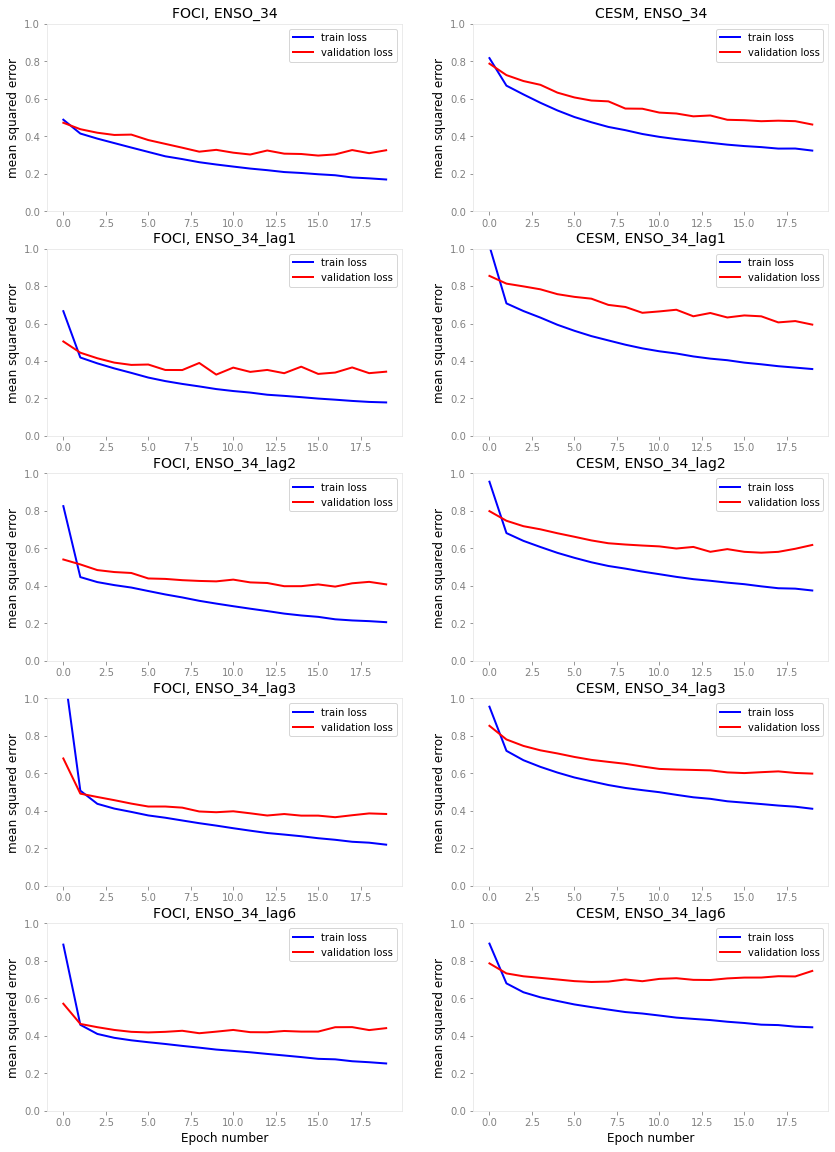

In [67]:
# Plot train and val_loss (mse), for both models and ALL target horizons:
fig, axes = plt.subplots(5, 2, figsize=(14, 20))

# Loop over target horizons:
for i, t_name in enumerate(target_names):

    # FOCI
    axes[i, 0].plot(
        histories_CNNfc_FOCI_classification[t_name].history["loss"], color="blue", label="train loss"
    )
    axes[i, 0].plot(
        histories_CNNfc_FOCI_classification[t_name].history["val_loss"],
        color="red",
        label="validation loss",
    )
    axes[i, 0].set_ylabel("mean squared error", fontsize=12)
    axes[i, 0].set_ylim([0, 1])
    axes[i, 0].set_title(f"FOCI, {t_name}", fontsize=14)
    axes[i, 0].legend()

    # CESM
    axes[i, 1].plot(
        histories_CNNfc_CESM_classification[t_name].history["loss"], color="blue", label="train loss"
    )
    axes[i, 1].plot(
        histories_CNNfc_CESM_classification[t_name].history["val_loss"],
        color="red",
        label="validation loss",
    )
    axes[i, 1].set_ylabel("mean squared error", fontsize=12)
    axes[i, 1].set_ylim([0, 1])
    axes[i, 1].set_title(f"CESM, {t_name}", fontsize=14)
    axes[i, 1].legend()

axes[- 1, 0].set_xlabel("Epoch number", fontsize=12)
axes[- 1, 1].set_xlabel("Epoch number", fontsize=12)

plt.show()

In [68]:
## Get predictions for both models and ALL target horizons:

# Initialize storages:
train_pred_CNNfc_FOCI = dict()
val_pred_CNNfc_FOCI = dict()
train_pred_CNNfc_CESM = dict()
val_pred_CNNfc_CESM = dict()

# FOCI models:
for i, t_name in enumerate(target_names):

    train_pred_CNNfc_FOCI[t_name] = models_CNNfc_FOCI_classification[t_name](train_input_scaled_FOCI)
    val_pred_CNNfc_FOCI[t_name] = models_CNNfc_FOCI_classification[t_name](val_input_scaled_FOCI)

# CESM models:
for i, t_name in enumerate(target_names):

    train_pred_CNNfc_CESM[t_name] = models_CNNfc_CESM_classification[t_name](train_input_scaled_CESM)
    val_pred_CNNfc_CESM[t_name] = models_CNNfc_CESM_classification[t_name](val_input_scaled_CESM)

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

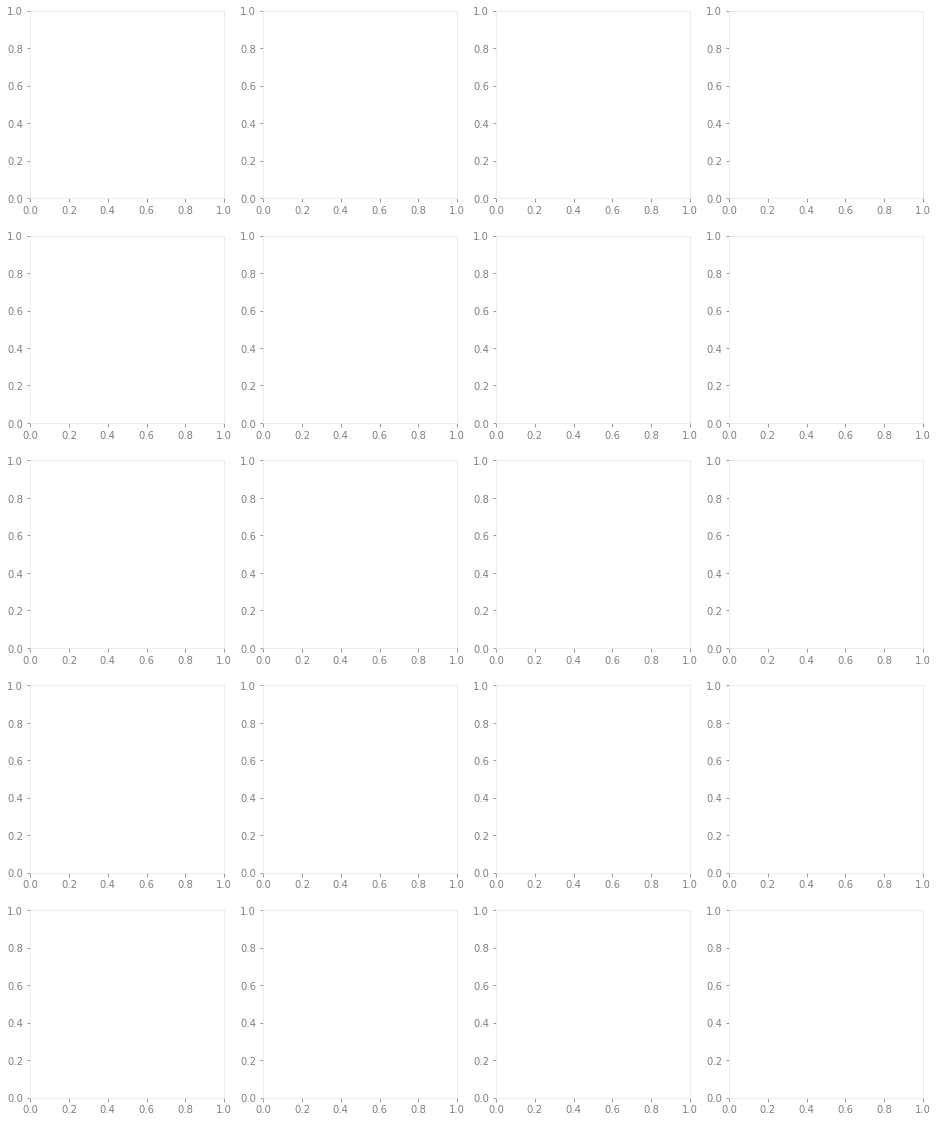

In [71]:
## Plot histogram of predictions on train data:
nBins = 100
fig, axes = plt.subplots(5, 4, figsize=(16, 20))

# Loop over predictions:
for i, t_name in enumerate(target_names):

    # FOCI
    axes[i, 0].hist(
        training["targets"]['FOCI'][t_name], nBins, color="grey", label="true targets"
    )
    axes[i, 0].set_ylabel("Counts", fontsize=12)
    axes[i, 0].set_title(f"FOCI, {t_name}")
    axes[i, 0].set_xlim([-3, 3])
    axes[i, 0].legend()
    axes[i, 1].hist(
        np.array(train_pred_CNNfc_FOCI[t_name]),
        nBins,
        color="blue",
        label="train pred",
    )
    axes[i, 0].set_title(f"FOCI, {t_name}")
    axes[i, 1].set_xlim([-3, 3])
    axes[i, 1].legend()
    # CESM
    axes[i, 2].hist(
        training["targets"]['CESM'][t_name], nBins, color="grey", label="true targets"
    )
    axes[i, 0].set_title(f"CESM, {t_name}")
    axes[i, 2].set_xlim([-3, 3])
    axes[i, 2].legend()
    axes[i, 3].hist(
        np.array(train_pred_CNNfc_CESM[t_name]),
        nBins,
        color="red",
        label="train pred",
    )
    axes[i, 0].set_title(f"CESM, {t_name}")
    axes[i, 3].set_xlim([-3, 3])
    axes[i, 3].legend()

# Add x-axes labels:
axes[-1, 0].set_xlabel("Target interval", fontsize=12)
axes[-1, 1].set_xlabel("Pred interval", fontsize=12)
axes[-1, 2].set_xlabel("Target interval", fontsize=12)
axes[-1, 3].set_xlabel("Pred interval", fontsize=12)

plt.show()

### CNN / fc: Evaluation

In [ ]:
## Check loss (mse) and correlation of true targets vs. model predictions:

# FOCI
print("FOCI\n====")
print(
    "Loss (mse) on TRAIN data with CNN / fc [lag0, lag1, lag2, lag3, lag6]:",
    [
        np.round(
            np.mean((train_pred_CNNfc_FOCI[i][:, 0] - train_target_FOCI[i]) ** 2),
            3,
        )
        for i in train_pred_CNNfc_FOCI
    ],
)
print(
    "Loss (mse) on  VAL  data with CNN / fc [lag0, lag1, lag2, lag3, lag6]:",
    [
        np.round(
            np.mean((val_pred_CNNfc_FOCI[i][:, 0] - val_target_FOCI[i]) ** 2),
            3,
        )
        for i in train_pred_CNNfc_FOCI
    ],
)
print(
    "Corr.Coeff on TRAIN data with CNN / fc [lag0, lag1, lag2, lag3, lag6]:",
    [
        np.round(
            np.corrcoef(
                np.stack([train_pred_CNNfc_FOCI[i][:, 0], train_target_FOCI[i]])
            )[0, 1],
            3,
        )
        for i in train_pred_CNNfc_FOCI
    ],
)
print(
    "Corr.Coeff on  VAL  data with CNN / fc [lag0, lag1, lag2, lag3, lag6]:",
    [
        np.round(
            np.corrcoef(np.stack([val_pred_CNNfc_FOCI[i][:, 0], val_target_FOCI[i]]))[
                0, 1
            ],
            3,
        )
        for i in train_pred_CNNfc_FOCI
    ],
)

# CESM
print("\nCESM\n====")
print(
    "Loss (mse) on TRAIN data with CNN / fc [lag0, lag1, lag2, lag3, lag6]:",
    [
        np.round(
            np.mean((train_pred_CNNfc_CESM[i][:, 0] - train_target_CESM[i]) ** 2),
            3,
        )
        for i in train_pred_CNNfc_CESM
    ],
)
print(
    "Loss (mse) on  VAL  data with CNN / fc [lag0, lag1, lag2, lag3, lag6]:",
    [
        np.round(
            np.mean((val_pred_CNNfc_CESM[i][:, 0] - val_target_CESM[i]) ** 2),
            3,
        )
        for i in train_pred_CNNfc_CESM
    ],
)
print(
    "Corr.Coeff on TRAIN data with CNN / fc [lag0, lag1, lag2, lag3, lag6]:",
    [
        np.round(
            np.corrcoef(
                np.stack([train_pred_CNNfc_CESM[i][:, 0], train_target_CESM[i]])
            )[0, 1],
            3,
        )
        for i in train_pred_CNNfc_CESM
    ],
)
print(
    "Corr.Coeff on  VAL  data with CNN / fc [lag0, lag1, lag2, lag3, lag6]:",
    [
        np.round(
            np.corrcoef(np.stack([val_pred_CNNfc_CESM[i][:, 0], val_target_CESM[i]]))[
                0, 1
            ],
            3,
        )
        for i in train_pred_CNNfc_CESM
    ],
)

In [ ]:
# Define function to specify bar color, according to sign of values:
def bar_color(data, color_pos, color_neg):
    return np.where(data.values > 0, color_pos, color_neg).T

In [ ]:
## Fidelity check: Plot VALIDATION targets as bar plot (red / blue) vs. predictions as black line

# Plot first 500 time steps only:
fig, axes = plt.subplots(5, 2, figsize=[16, 20], sharey=True, sharex=True)

# Loop over predictions:
for i, t_name in enumerate(val_pred_CNNfc_FOCI):

    # FOCI
    axes[i, 0].bar(
        x=range(len(val_target_FOCI[t_name][:500])),
        height=val_target_FOCI[t_name][:500],
        color=bar_color(val_target_FOCI[t_name][:500], "r", "b"),
        label="true targets",
        alpha=0.3,
    )
    axes[i, 0].plot(
        val_pred_CNNfc_FOCI[t_name][:500, 0], label="val pred", color="black"
    )
    axes[i, 0].legend()
    axes[i, 0].set_title("FOCI, " + t_name, fontsize=12)
    axes[i, 0].set_ylabel("Index", fontsize=12)

    # CESM
    axes[i, 1].bar(
        x=range(len(val_target_CESM[t_name][:500])),
        height=val_target_CESM[t_name][:500],
        color=bar_color(val_target_CESM[t_name][:500], "r", "b"),
        label="true targets",
        alpha=0.3,
    )
    axes[i, 1].plot(
        val_pred_CNNfc_CESM[t_name][:500, 0], label="val pred", color="black"
    )
    axes[i, 1].legend()
    axes[i, 1].set_title("CESM, " + t_name, fontsize=12)


axes[len(val_pred_CNNfc_FOCI) - 1, 0].set_xlabel("Time [month]", fontsize=12)
axes[len(val_pred_CNNfc_FOCI) - 1, 1].set_xlabel("Time [month]", fontsize=12)

In [31]:
# NEXT steps:

### Repeat experiments with fc_hidden_activation='linear': Is that the reason for the cut-off predictions, compared
### to targets in distribution histograms?

### Evaluation of "accuracy" in form of TP, TN, FP, FN and F-score. Does that make sense?

### Check cross-validation: Can we use the model trained on FOCI data to predict on CESM data, and vice versa?

### Discussion on single-run experiments with ALL target horizons with CNN/fc model:
#   Model fails on the peaks, as seen in distribution of predictions vs. targets and also in Fidelity check plot.
#   See higher and more realistic frequency of ENSO events in CESM data: El Nino every 3-4 years, as in real-world.
#   Find higher loss (mse) but worse correlation for FOCI, compared to CESM.

### Then try to train models on lagged targets: What's the task? Predicting transfer from neutral state to either
### El Nino or La Nina? (Willi talked about "contingency tables" in our last PI meeting. What's that?)

## More from Nils

### Create pandas dataframes to better be able to sort data

In [ ]:
def select_NN_setup(
    CNN_filters,
    CNN_kernel_sizes,
    fc_units,
    fc_hidden_activation,
    loss_function,
    input_length,
):
    pass

NN_setup = {
    **basic_CNN.get_args(select_NN_setup),
    **preprocessing_dict.get_args(select_NN_setup),
}
print(NN_setup)

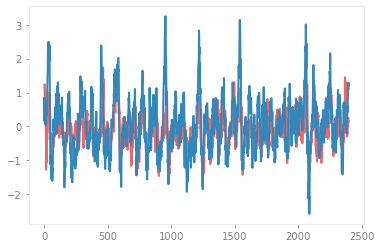

In [309]:
df_val_FOCI = pd.DataFrame(
    dict(
        [
            (t_name, val_pred_CNNfc_FOCI[t_name].numpy().flatten())
            for t_name in val_pred_CNNfc_FOCI
        ]
    )
)
df_val_FOCI.index.name = "index"
df_val_FOCI.reset_index(drop=True, inplace=True)
val_target_FOCI.reset_index(drop=True, inplace=True)

d = {"prediction": df_val_FOCI, "target": val_target_FOCI}
df_FOCI = pd.concat(d.values(), axis=1, keys=d.keys())

df_val_CESM = pd.DataFrame(
    dict(
        [
            (t_name, val_pred_CNNfc_CESM[t_name].numpy().flatten())
            for t_name in val_pred_CNNfc_CESM
        ]
    )
)
df_val_CESM.index.name = "index"
df_val_CESM.reset_index(drop=True, inplace=True)
val_target_CESM.reset_index(drop=True, inplace=True)

d = {"prediction": df_val_CESM, "target": val_target_CESM}
df_CESM = pd.concat(d.values(), axis=1, keys=d.keys())

d = {"CESM": df_CESM, "FOCI": df_FOCI}
df = pd.concat(d.values(), axis=1, keys=d.keys())

df = DataFrameMultiColumn(df)
plt.plot(df.loc_multicolumn(["ENSO_34_lag6", "FOCI"]))

In [262]:
threshold = 1
mel = 5
df_el_nino = df.apply(
    el_nino,
    axis=0,
    raw=True,
    result_type=None,
    **dict(threshold=threshold, min_event_length=mel)
)
df_la_nina = df.apply(
    la_nina,
    axis=0,
    raw=True,
    result_type=None,
    **dict(threshold=-threshold, min_event_length=mel)
)

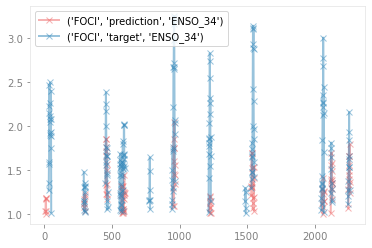

In [263]:
plt.plot(df[df_el_nino].loc[:, cols], label=cols, linestyle="-", marker="x", alpha=0.5)
plt.legend()

FOCI ENSO_34
CESM ENSO_34
FOCI ENSO_34_lag1
CESM ENSO_34_lag1
FOCI ENSO_34_lag2
CESM ENSO_34_lag2
FOCI ENSO_34_lag3
CESM ENSO_34_lag3
FOCI ENSO_34_lag6
CESM ENSO_34_lag6


Text(0.5, 0, 'Time [month]')

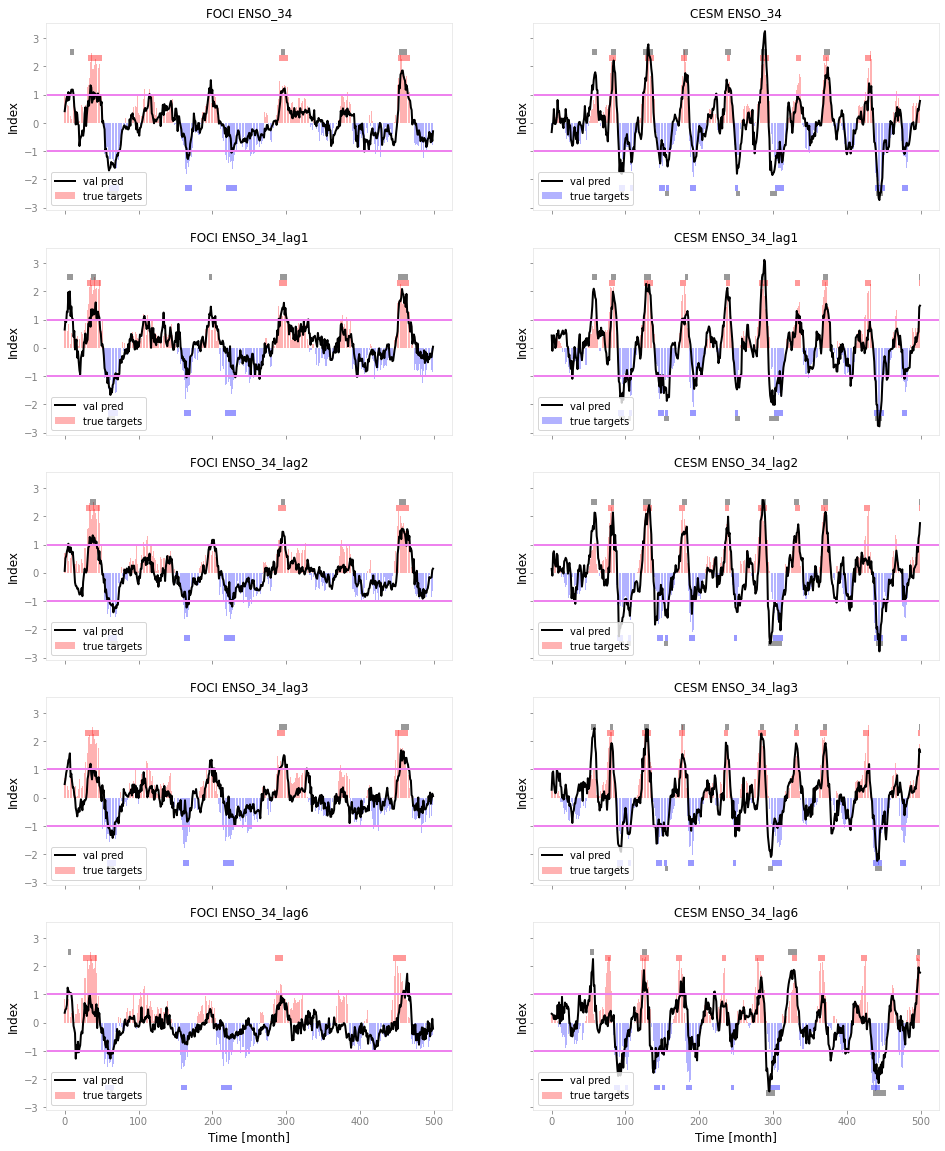

In [265]:
## Fidelity check: Plot VALIDATION targets as bar plot (red / blue) vs. predictions as black line
# Plot also markers for El Nino and La Nina along x axis
n = 500
x = range(n)

df_plot = df.head(n)
df_el_nino_plot = df_el_nino.head(n)
df_la_nina_plot = df_la_nina.head(n)
df_bar_color = df_plot.apply(
    bar_color, axis=0, raw=False, result_type=None, args=("r", "b")
)
# Plot first 500 time steps only:
fig, axes = plt.subplots(5, 2, figsize=[16, 20], sharey=True, sharex=True)


# Loop over predictions:
for i, t_name in enumerate(val_pred_CNNfc_FOCI):
    for j, m_name in enumerate(["FOCI", "CESM"]):
        print(f"{m_name} {t_name}")
        predic_cols = loc_multicolumn(df, [t_name, m_name, "prediction"])
        target_cols = loc_multicolumn(df, [t_name, m_name, "target"])

        # bar plot for prediction
        axes[i, j].bar(
            x=x,
            height=df_plot.loc[:, target_cols].values.flatten(),
            color=df_bar_color.loc[:, target_cols].values.flatten(),
            label="true targets",
            alpha=0.3,
        )
        # lineplot for predictions
        axes[i, j].plot(
            df_plot.loc[:, predic_cols], alpha=1, label="val pred", color="black"
        )
        axes[i, j].set_title(f"{m_name} {t_name}", fontsize=12)
        axes[i, j].set_ylabel("Index", fontsize=12)
        # fillbetween plots for el nino, la nina for both prediction and target

        # --- El Nino ---
        axes[i, j].axhline(threshold, color="violet", alpha=1)
        # target
        axes[i, j].fill_between(
            x,
            2.2,
            2.4,
            where=df_el_nino_plot.loc[:, target_cols].values.flatten(),
            alpha=0.4,
            facecolor="r",
            edgecolor=None,
        )
        # val prediction
        axes[i, j].fill_between(
            x,
            2.4,
            2.6,
            where=df_el_nino_plot.loc[:, predic_cols].values.flatten(),
            alpha=0.4,
            facecolor="k",
            edgecolor=None,
        )
        # --- La Nina ---
        axes[i, j].axhline(-threshold, color="violet", alpha=1)
        # target
        axes[i, j].fill_between(
            x,
            -2.2,
            -2.4,
            where=df_la_nina_plot.loc[:, target_cols].values.flatten(),
            alpha=0.4,
            facecolor="b",
            edgecolor=None,
        )
        # val prediction
        axes[i, j].fill_between(
            x,
            -2.4,
            -2.6,
            where=df_la_nina_plot.loc[:, predic_cols].values.flatten(),
            alpha=0.4,
            facecolor="k",
            edgecolor=None,
        )


# plot legends
for ax in axes.flatten():
    ax.legend(loc="lower left")

axes[-1, 0].set_xlabel("Time [month]", fontsize=12)
axes[-1, 1].set_xlabel("Time [month]", fontsize=12)

fig.suptitle(f"{NN_setup}\n")
fig.tight_layout()
fig.savefig(f"{NN_setup}")

In [290]:
from sklearn.metrics import confusion_matrix

dict_to_array = lambda d: np.array([d[k] for k in d])


def f_score_func(tn, fp, fn, tp):
    return 2 * tp / (2 * tp + fp + fn)


def recall_func(tn, fp, fn, tp):
    return tp / (tp + fn)


def precission_func(tn, fp, fn, tp):
    return tp / (tp + fp)


def statistical_scores(y_true, y_pred):
    cm = confusion_matrix(
        y_true=y_true,
        y_pred=y_pred,
    )
    tn, fp, fn, tp = cm.ravel()
    f_score = f_score_func(tn, fp, fn, tp)
    recall = recall_func(tn, fp, fn, tp)
    precission = precission_func(tn, fp, fn, tp)
    return tn, fp, fn, tp, recall, precission, f_score

In [297]:
%%capture cap --no-stderr
print(f"Basic model setup:\n{NN_setup}\n==============\n")
print(f"El Nino : threshold = {threshold}, minimal event length = {mel}")
print(f"La Nina : threshold = {-threshold}, minimal event length = {mel}\n")
print(f"tn, \tfp, \tfn, \ttp,\treca.,\tprec.,\tF1,\tlabel")
for m_name in ["FOCI", "CESM"]:
    print(f"==== {m_name} ====")
    for e_name, event in zip(["El Nino", "La Nina"], [df_el_nino, df_la_nina]):
        print(f"---- {e_name} ----")
        for t_name in val_pred_CNNfc_FOCI:
            tn, fp, fn, tp, recall, precission, f_score = statistical_scores(
                y_true=event.loc[:, loc_multicolumn(event, [t_name, m_name, "target"])],
                y_pred=event.loc[
                    :, loc_multicolumn(event, [t_name, m_name, "prediction"])
                ],
            )
            print(
                f"{tn}, \t{fp}, \t{fn}, \t{tp}, \t{recall:.2f}, \t{precission:.2f}, \t{f_score:.2f}, \t{t_name}"
            )

In [298]:
with open(f"{NN_setup}.txt", "w") as f:
    f.write(cap.stdout)
print(cap)

Basic model setup:
{'CNN_filters': [10, 20], 'CNN_kernel_sizes': [5, 5], 'fc_units': [20, 10], 'fc_hidden_activation': 'linear', 'loss_function': 'mse', 'input_length': 24}

El Nino : threshold = 1, minimal event length = 5
La Nina : threshold = -1, minimal event length = 5

tn, 	fp, 	fn, 	tp,	reca.,	prec.,	F1,	label
==== FOCI ====
---- El Nino ----
2178, 	15, 	100, 	102, 	0.50, 	0.87, 	0.64, 	ENSO_34
2139, 	54, 	98, 	104, 	0.51, 	0.66, 	0.58, 	ENSO_34_lag1
2186, 	7, 	120, 	82, 	0.41, 	0.92, 	0.56, 	ENSO_34_lag2
2178, 	15, 	143, 	59, 	0.29, 	0.80, 	0.43, 	ENSO_34_lag3
2180, 	8, 	199, 	8, 	0.04, 	0.50, 	0.07, 	ENSO_34_lag6
---- La Nina ----
2261, 	24, 	79, 	31, 	0.28, 	0.56, 	0.38, 	ENSO_34
2262, 	23, 	80, 	30, 	0.27, 	0.57, 	0.37, 	ENSO_34_lag1
2251, 	34, 	76, 	34, 	0.31, 	0.50, 	0.38, 	ENSO_34_lag2
2280, 	5, 	79, 	31, 	0.28, 	0.86, 	0.42, 	ENSO_34_lag3
2257, 	28, 	94, 	16, 	0.15, 	0.36, 	0.21, 	ENSO_34_lag6
==== CESM ====
---- El Nino ----
2029, 	33, 	157, 	176, 	0.53, 	0.84, 	0.65, 	

### A few Idea by Nils:

- we could also try a classification task: La Nina, Neutral, El Nino and see how different they are them